# Inference of species-level microbial interactions

Author: Monica R. Ticlla Ccenhua <br>
e-mail: mticlla@gmail.com monicaroxana.ticllaccenhua@unibas.ch

**Summary**

To infer associations among taxa, we created genus-level and species-level interaction networks with SParse InveresE Covariance Estimation for Ecological ASociation Inference (SPIEC-EASI); available as an R package (_SpiecEasi_). SPIEC-EASI uses CLR-transformed abundances to infer a graph model where nodes represent taxa and edges represent associations between taxa that cannot be explained by alternative paths in the graph <cite data-cite="2542765/2GNQQCBM"></cite>. We selected the neighborhood selection method of SPIEC-EASI. To infer species-level interaction networks, we used the WMS-S taxonomic profiles and considered only those species present in at least 3 samples. To infer genus-level interaction networks, we used the 16S-AS taxonomic profiles and considered only those genera present in at least 5\% of the samples included in the dataset; genera are more likely to be shared across samples, thus we increased the presence threshold.

This notebooks presents the inference of species-level interactions.

In [1]:
report_date = %env REPORT_DATE
print(report_date)

2020-07-17


## 0. Set-up working environment

**Set-up working directory**

In [2]:
%%capture
cd ../

**Import python modules**

In [3]:
%load_ext rpy2.ipython

.Rprofile: Setting Swiss repository



**Import R packages**

In [4]:
%%capture
%%R
library(phyloseq)
library(ggplot2)
library(hrbrthemes)
hrbrthemes::import_roboto_condensed()
library(RColorBrewer)
library(grid)
library(gridExtra)
library(zCompositions)
library(factoextra)
library(vegan)
library(ggpubr)
library(ggrepel)
library("scales")
library(SpiecEasi)
library(ggraph)
library(graphlayouts)

options("width"=200)

## 1. Input files

### 1.1 WMS-S taxonomic profiles

In [5]:
%%R
# Load taxonomic abundance profiles (relative abundances)
wms_abundance_table_file <- "./data/interim/MetaSnk/wms_cases/PhlAnProf/metaphlan/profiles_merged/wms_cases_abundances_table.txt"
wms_abundance_table <- read.table(wms_abundance_table_file, header=TRUE, sep='\t', 
                                  stringsAsFactors=FALSE, quote = "", check.names=FALSE, row.names=1)
print(wms_abundance_table[1:5,1:2])
cat("\nDimensions of data before filtering\n")
cat("\nNr of samples: ")
cat(dim(wms_abundance_table)[2])
cat("\nNr of taxa: ")
cat(dim(wms_abundance_table)[1])

# Remove samples with high levels of contaminant spp.
# ---------------------------------------------------
# List of contaminated samples
wms_samples_highcont_file <- "./data/interim/wms_contaminated_samples_ids.tsv"
wms_samples_highcont <- readLines(file(wms_samples_highcont_file))
cat("\n\nNumber of samples highly contaminated: ")
cat(length(wms_samples_highcont))
cat("\nSamples highly contaminated: \n")
print(wms_samples_highcont)
metaphlan_all_spp_contaminated_samples_ix <- which(colnames(wms_abundance_table) %in% wms_samples_highcont)
wms_abundance_table <- wms_abundance_table[,-metaphlan_all_spp_contaminated_samples_ix]
print(dim(wms_abundance_table))

# Remove samples with high percentage of unclassified reads
# ---------------------------------------------------------
# Distribution of percentage of "unclassified" reads per sample
cat("\n\nDistribution of percentage of 'unclassified' reads per sample")
print(table(t(wms_abundance_table["unclassified",])))
has_only_unclassified <- as.vector(t(wms_abundance_table["unclassified",])==100)
mp_unclassified_samples <- colnames(wms_abundance_table)[has_only_unclassified]
cat("Samples with only unclassified reads: \n")
cat(colnames(wms_abundance_table)[has_only_unclassified])
wms_abundance_table <- wms_abundance_table[,!has_only_unclassified]

# Remove samples with abnormal percentage of human DNA
#-----------------------------------------------------
wms_stats_file <- "./data/interim/MetaSnk/wms_cases/preQC/summary_stats/wms_cases_preqc_samples_summary.tsv"
wms_stats <- read.table(wms_stats_file, sep="\t", header=TRUE, row.names=1)
cat("\n\nPercent Human: \n")
print(summary(wms_stats$filter_human_pct_disc))
samples_wit_lowpct_human <- rownames(wms_stats)[wms_stats$filter_human_pct_disc<50]
cat("\nSamples with low percentage of human reads (<50%): ",length(samples_wit_lowpct_human), "\n")
cat(samples_wit_lowpct_human)
is_lowpct_human <- colnames(wms_abundance_table) %in% samples_wit_lowpct_human
cat("\nSamples with low percentage of human reads (<50%) not yet removed by previous filters: ",
    sum(is_lowpct_human), "\n")
wms_abundance_table <- wms_abundance_table[,!is_lowpct_human]

# Remove taxa with zero total counts
taxa_has_only_zeros <- rowSums(wms_abundance_table)==0
wms_abundance_table <- wms_abundance_table[!taxa_has_only_zeros,]
cat("\n\nNr of taxa with zero totals: \n")
cat(sum(taxa_has_only_zeros))

cat("\n\nDimensions of data after filtering\n")
cat("\nNr of samples: ")
cat(dim(wms_abundance_table)[2])
cat("\nNr of taxa: ")
cat(dim(wms_abundance_table)[1])

                                                                                          M00186   M00158
k__Bacteria                                                                            100.00000 89.48721
k__Bacteria|p__Actinobacteria                                                           91.74722 36.23369
k__Bacteria|p__Actinobacteria|c__Actinobacteria                                         91.74722 36.23369
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales                      91.74722 36.23369
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae   0.00000  0.00000

Dimensions of data before filtering

Nr of samples: 129
Nr of taxa: 1094

Number of samples highly contaminated: 22
Samples highly contaminated: 
 [1] "M00176" "M00161" "M00226" "M00269" "M00081" "M00111" "M00065" "M00084" "M00094" "M00054" "M00219" "M00276" "M00086" "M00135" "M00004" "M00090" "M00229" "M00122" "M00033" "M00001" "M00241"
[22] "M00218"
[1] 1094 

**Split taxon abundances by taxonomic ranks**

In [6]:
%%R
# Taxon IDs per rank
kingdoms <- grep("\\|",rownames(wms_abundance_table), value=TRUE, invert=TRUE)
species_all <- grep("^k__[[:graph:]]*\\|s__[^\\|]*$", rownames(wms_abundance_table), value=TRUE)
cat("\nNr of species: ", length(species_all))

# Remoce Species/strains flagged as contaminants by decontam
# List of potential contamiant spp.
wms_contaminants_ids_file <- "./data/interim/wms_contaminants_decontam.tsv"
wms_contaminants_ids <- read.table(wms_contaminants_ids_file, sep='\t',header=TRUE, stringsAsFactors=FALSE)

species_all <- names(which(sapply(species_all, 
                                   function(x){
                                       if(sum(stringr::str_detect(x,wms_contaminants_ids$sp_id))>0){
                                           FALSE
                                       }else{
                                           TRUE
                                       }
                                   })))
cat("\nNr of species after removing potential contaminants: ", length(species_all))

# Species abundances
# ---------------------
# Relative abundances (%)
wms_all_spp_abund_table <- wms_abundance_table[species_all,]
wms_all_spp_abund_table <- wms_all_spp_abund_table[rowSums(wms_all_spp_abund_table)>0,]
# Relative counts
wms_all_spp_counts_table <- t(apply(wms_all_spp_abund_table,1,
                                   function(x,x_totals){round((x*x_totals)/100)}, 
                                   x_totals=wms_stats[colnames(wms_all_spp_abund_table),"total_kept_reads"]))

# Taxonomy assignment
wms_all_spp_taxonomy <- as.data.frame(do.call(rbind,strsplit(rownames(wms_all_spp_counts_table),"\\|")))
colnames(wms_all_spp_taxonomy) <- c("Kingdom","Phylum","Class","Order","Family","Genus","Species")
rownames(wms_all_spp_taxonomy) <- wms_all_spp_taxonomy$Species

rownames(wms_all_spp_counts_table) <- wms_all_spp_taxonomy$Species
rownames(wms_all_spp_abund_table) <- wms_all_spp_taxonomy$Species


Nr of species:  195
Nr of species after removing potential contaminants:  188

### 1.2 Mode of metabolism for species

In [7]:
%%R
wms_spp_metabolism_req_file <- "./data/raw/metadata/species_oxygen_tolerance.csv"
wms_spp_metabolism_req <- read.table(wms_spp_metabolism_req_file, header=TRUE, sep='\t', 
                                     stringsAsFactors=FALSE, quote="", check.names=FALSE, row.names=1)
head(wms_spp_metabolism_req)

                            oxygen_requirement     gram                          reference
Actinomyces_cardiffensis              anaerobe positive https://bacdive.dsmz.de/strain/184
Actinomyces_graevenitzii  Facultative anaerobe positive https://bacdive.dsmz.de/strain/186
Actinomyces_johnsonii                 anaerobe positive https://bacdive.dsmz.de/strain/190
Actinomyces_massiliensis              anaerobe positive https://bacdive.dsmz.de/strain/192
Actinomyces_naeslundii                anaerobe positive https://bacdive.dsmz.de/strain/154
Actinomyces_odontolyticus             anaerobe positive https://bacdive.dsmz.de/strain/155


## 2 Identification of species-level interactions using compositional data analysis on WMS-S taxonomic profiles

### 2.1 Centred-log ratio (CLR) transformation of abundances

In [8]:
%%R
print(par('din'))

# CLR-transformation of counts
# ----------------------------
wms_all_spp_counts_clr <-  wms_all_spp_counts_table

# Filter rare species
# Keep those present in at least three samples
spp_prevalence_cutoff <- 3
cat("\nPrevalence cut-off: ")
cat(spp_prevalence_cutoff)
spp_is_abv_cutoff <- as.vector(rowSums(wms_all_spp_counts_clr>0) >= spp_prevalence_cutoff)
wms_all_spp_counts_clr <- wms_all_spp_counts_clr[spp_is_abv_cutoff,]
cat("\nNr. species removed (prevalence < 3): ", sum(!spp_is_abv_cutoff))

# Remove samples with zero totals
wms_sample_has_zero_totals <- as.vector(colSums(wms_all_spp_counts_clr)==0)
if(sum(wms_sample_has_zero_totals)>0){
    cat("\nSamples(IDs) with zero totals removed: ")
    cat(colnames(wms_all_spp_counts_clr)[wms_sample_has_zero_totals])
    wms_all_spp_counts_clr <- wms_all_spp_counts_clr[,!wms_sample_has_zero_totals]
}
cat("\nDimensions(species-by-samples) of filtered table: ",
    dim(wms_all_spp_counts_clr),'\n')

# Then, replace zeroes, returns a sample-by-features table (samples as rows)
wms_all_spp_counts_clr <- cmultRepl(t(wms_all_spp_counts_clr), 
                                         label=0, method="CZM", output="p-counts")
cat("\nSamples-by-Species table:\n")
# Finally, apply CLR-transformation
wms_all_spp_counts_clr <- t(apply(wms_all_spp_counts_clr, 1, function(x){log(x) - mean(log(x))}))
print(wms_all_spp_counts_clr[1:5,1:2])

# Compute Aitchison distances
# ---------------------------
wms_all_spp_samples_pairwise_dist <- dist(wms_all_spp_counts_clr)
wms_all_spp_species_pairwise_dist <- dist(t(scale(wms_all_spp_counts_clr, center=FALSE, scale=FALSE)))

[1] 6.666667 6.666667

Prevalence cut-off: 3
Nr. species removed (prevalence < 3):  79
Dimensions(species-by-samples) of filtered table:  109 89 

Samples-by-Species table:
       s__Actinomyces_graevenitzii s__Actinomyces_odontolyticus
M00186                  -0.4112003                   -0.4112003
M00158                  -2.0135915                   -2.0135915
M00046                   9.4571348                   -2.0211635
M00125                  -1.9275136                   -1.9275136
M00208                  -4.3896610                   -4.3896610


### 2.2 Compositional biplots

**Principal component analysis (PCA) on CLR-transformed values**

In [9]:
%%R -w 800 -h 800 -u px
wms_spp_pca <- prcomp(wms_all_spp_counts_clr,  center=TRUE, scale=FALSE)

**Compositional biplot**

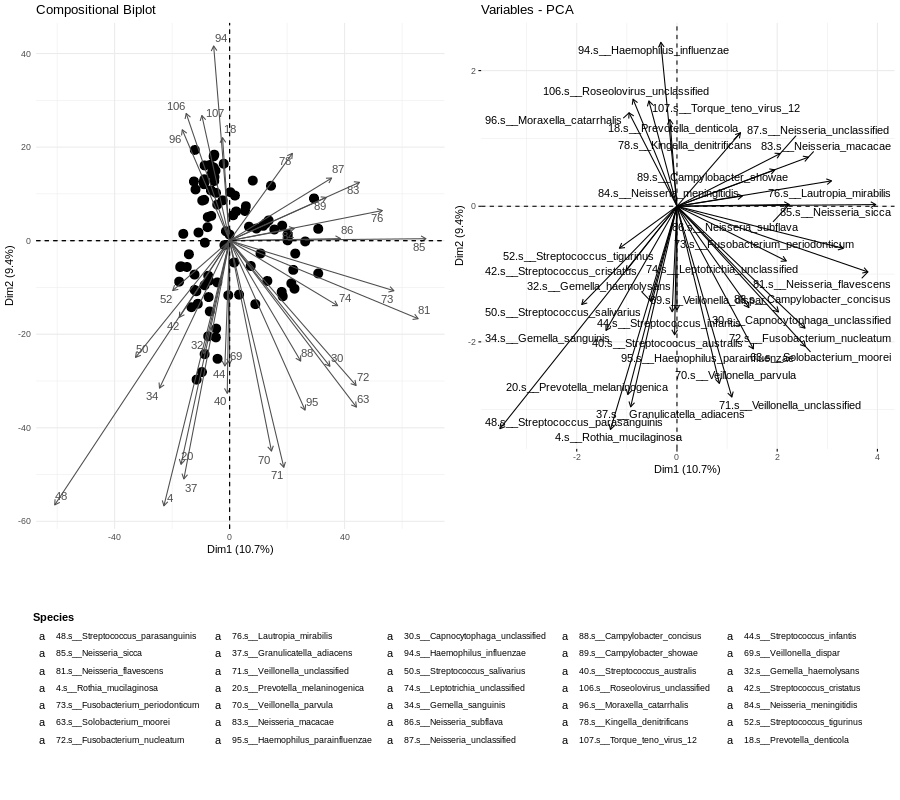

In [11]:
%%R -w 900 -h 800 -u px
# PCA-Biplot
# -----------
# We want numbers as labels for the variables
spp_name_numbers <- seq(1,length(colnames(wms_all_spp_counts_clr)))
names(spp_name_numbers) <- colnames(wms_all_spp_counts_clr)

rownames(wms_spp_pca$rotation) <- spp_name_numbers
wms_spp_pca_biplot <- fviz_pca_biplot(wms_spp_pca, 
                                      # Individuals
                                      geom.ind="point", pointsize = 4,
                                      repel=TRUE,
                                      label ="var", 
                                      select.var=list(cos2=35),
                                      col.var="#4d4d4d", 
                                      jitter=list("point",0.4,0.4),
                                      title = "Compositional Biplot") +
                        theme_minimal()

# PCA-Variables plot
# ------------------
spp_name_labels <- paste(spp_name_numbers, names(spp_name_numbers), sep=".")
wms_spp_pca_varplot <- fviz_pca_var(wms_spp_pca, label="none", axes = c(1, 2),
                                    select.var=list(cos2=35),
                                    repel = TRUE)

selected_spp <- as.numeric(row.names(wms_spp_pca_varplot$data))
spp_colors <- rep("black",length(selected_spp))

wms_spp_pca_varplot <- wms_spp_pca_varplot + 
                       geom_text_repel(aes(label = spp_name_labels[selected_spp], 
                                           colour = spp_name_labels[selected_spp]))+
                       scale_colour_manual(name="Species", 
                                           limits=spp_name_labels[selected_spp],
                                           labels=spp_name_labels[selected_spp],
                                           values=spp_colors) + 
                       theme(legend.position="bottom", legend.title=element_text(face="bold"))  +
                       guides(colour=guide_legend(title.position='top'))
wms_spp_pca_varplot_legend <- cowplot::get_legend(wms_spp_pca_varplot)

# PCA- varplot and biplot panel
# ------------------------------
pca_var_biplot_panel_layout <- rbind(c(1,2),
                                     c(1,NA),
                                     c(3,3))

grid.arrange(wms_spp_pca_biplot,
             wms_spp_pca_varplot + theme(legend.position="none"), 
             wms_spp_pca_varplot_legend,
             layout_matrix=pca_var_biplot_panel_layout, 
             widths=c(0.5,0.5), heights=c(0.6,0.1,0.3))

Lets color the dots reprenting samples in the biplot by the logratio of the two species whose logratio abundances contribute the most to the two first principal components of the biplot. The labels in the legend of the figures above is ordered in descending order of contribution to the principal components of the biplot. Thus the logratio of the abundances of _Streptococcus parasanguinis_ and _Neisseria Sicca_ are the ones contributing the most.

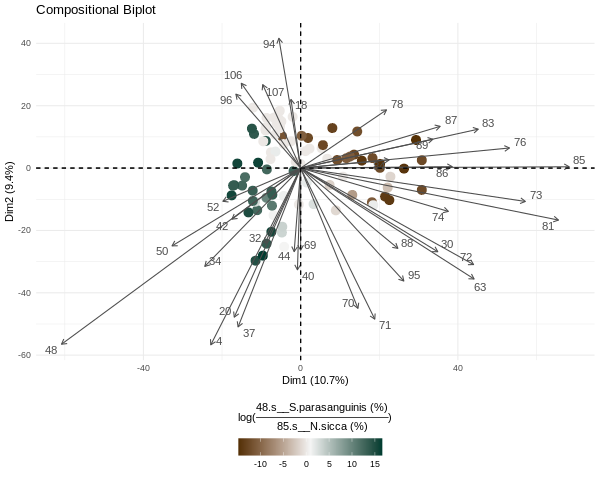

In [12]:
%%R -w 600 -u px
sparasanguinis_ix <- grep("s__Streptococcus_parasanguinis", colnames(wms_all_spp_counts_clr))
neisseria_unclassified_ix <- grep("s__Neisseria_sicca", colnames(wms_all_spp_counts_clr))
log_sparasang_to_neisse_ratio <- as.vector(wms_all_spp_counts_clr[,sparasanguinis_ix] - 
                                           wms_all_spp_counts_clr[,neisseria_unclassified_ix])

sparasang_label <- paste0(spp_name_numbers["s__Streptococcus_parasanguinis"],".","s__S.parasanguinis"," (%)")
nsicca_label <- paste0(spp_name_numbers["s__Neisseria_sicca"],".","s__N.sicca"," (%)")
legend_label <- expr(paste("log(", frac(!!sparasang_label,!!nsicca_label), ")"))

#legend_title <- expression(paste("log(", frac(italic("S. parasanguinis (%)"),italic("N. sicca (%)")),")"))
rownames(wms_spp_pca$rotation) <- spp_name_numbers
wms_spp_pca_biplot <- fviz_pca_biplot(wms_spp_pca, 
                                      # Individuals
                                      col.ind=log_sparasang_to_neisse_ratio,
                                      geom.ind="point", pointsize = 4,
                                      gradient.cols = c("#543005","#f5f5f5","#003c30"), 
                                      repel=TRUE,
                                      label ="var", 
                                      select.var=list(cos2=35),
                                      col.var="#4d4d4d", 
                                      #fill.var=biplot_text_colors,
                                      jitter=list("point",0.4,0.4),
                                      title = "Compositional Biplot") +
                        labs(colour=legend_label) + 
                        theme_minimal() + 
                        theme(legend.position="bottom") +
                        guides(colour=guide_colourbar(title.position="top", barwidth=10))
wms_spp_pca_biplot

### 2.3 Reconstruction of compositional network

**Inference of species-level microbial interactions with SPIEC-EASI**

In [15]:
%%R
wms_spp_counts_table_forSpiecEasi <- t(wms_all_spp_counts_table)[rownames(wms_all_spp_counts_clr),
                                                                 colnames(wms_all_spp_counts_clr)]
wms_spp_SpiecEasi <- suppressWarnings(spiec.easi(wms_spp_counts_table_forSpiecEasi, 
                                                method='mb', 
                                                lambda.min.ratio=1e-2,
                                                nlambda=20, 
                                                sel.criterion='bstars', 
                                                pulsar.select=TRUE,
                                                pulsar.params=list(rep.num=50, ncores=7, seed=10010)))

**Create the microbial interaction graph**

In [16]:
%%R
# Create igraph graph
# -------------------
#--Weights of edges
#
# beta coefficientes of edges (measures the strength of the interaction and the sign)
# From: https://www.rdocumentation.org/packages/SpiecEasi/versions/1.0.2
# " Note that since SPIEC-EASI is based on penalized estimators, the edge weights 
# are not directly comparable to SparCC (or Pearson/Spearman correlation coefficients)"
wms_spp_edge_betas <- symBeta(getOptBeta(wms_spp_SpiecEasi), mode='maxabs')
# re-order edges as they will be in igraph graph
wms_spp_edge_betas <- summary(wms_spp_edge_betas)[with(summary(wms_spp_edge_betas), order(i)),]

# the igraph graph
wms_spp_SpiecEasi.ig <- adj2igraph(getRefit(wms_spp_SpiecEasi))

# Set attributes for edges
wms_spp_edge_sign <- rep(NA, dim(wms_spp_edge_betas)[1])
wms_spp_edge_sign[wms_spp_edge_betas[,3] < 0] <- "Negative"
wms_spp_edge_sign[wms_spp_edge_betas[,3] > 0] <- "Positive"

wms_spp_SpiecEasi.ig <- igraph::set.edge.attribute(wms_spp_SpiecEasi.ig,
                                                   "beta", value=wms_spp_edge_betas[,3])
wms_spp_SpiecEasi.ig <- igraph::set.edge.attribute(wms_spp_SpiecEasi.ig,
                                                   "sign", value=wms_spp_edge_sign)
# Set attributes for vertices
wms_spp_SpiecEasi.ig <- igraph::set.vertex.attribute(wms_spp_SpiecEasi.ig, 
                                                     "name", 
                                                     value=colnames(wms_spp_counts_table_forSpiecEasi))
wms_spp_SpiecEasi.ig <- igraph::set.vertex.attribute(wms_spp_SpiecEasi.ig, 
                                                     "label", value=spp_name_labels)
# taxon mean relative abundance
wms_spp_mean_ra <- rowMeans(wms_all_spp_abund_table[colnames(wms_spp_counts_table_forSpiecEasi), 
                                                  rownames(wms_spp_counts_table_forSpiecEasi)])
wms_spp_SpiecEasi.ig <- igraph::set.vertex.attribute(wms_spp_SpiecEasi.ig, 
                                                     "Abundance", value=wms_spp_mean_ra)
# Mode of metabolism
wms_spp_metabolism <- wms_spp_metabolism_req[gsub("^s__","",colnames(wms_spp_counts_table_forSpiecEasi)),
                                             "oxygen_requirement"]
wms_spp_metabolism <- factor(wms_spp_metabolism, 
                             levels=c("aerobe","microaerophile","Facultative anaerobe",
                                      "aerobe; capnophilic; facultative anaerobe","anaerobe"), 
                             labels=c("Aerobe","Microaerophile","Facultative Anaerobe", 
                                      "Ae/C/FA","Anaerobe"))
wms_spp_SpiecEasi.ig <- igraph::set.vertex.attribute(wms_spp_SpiecEasi.ig, 
                                                     "Metabolism", value=as.character(wms_spp_metabolism))

summary(wms_spp_SpiecEasi.ig)

# Save graph
save(wms_spp_SpiecEasi.ig, file = "./data/processed/wms_spp_level_network.RDA")

IGRAPH b598d9a UNW- 109 136 -- 
+ attr: name (v/c), label (v/c), Abundance (v/n), Metabolism (v/c), weight (e/n), beta (e/n), sign (e/c)


**Visualize interaction graph**

[1] 16.66667 19.44444


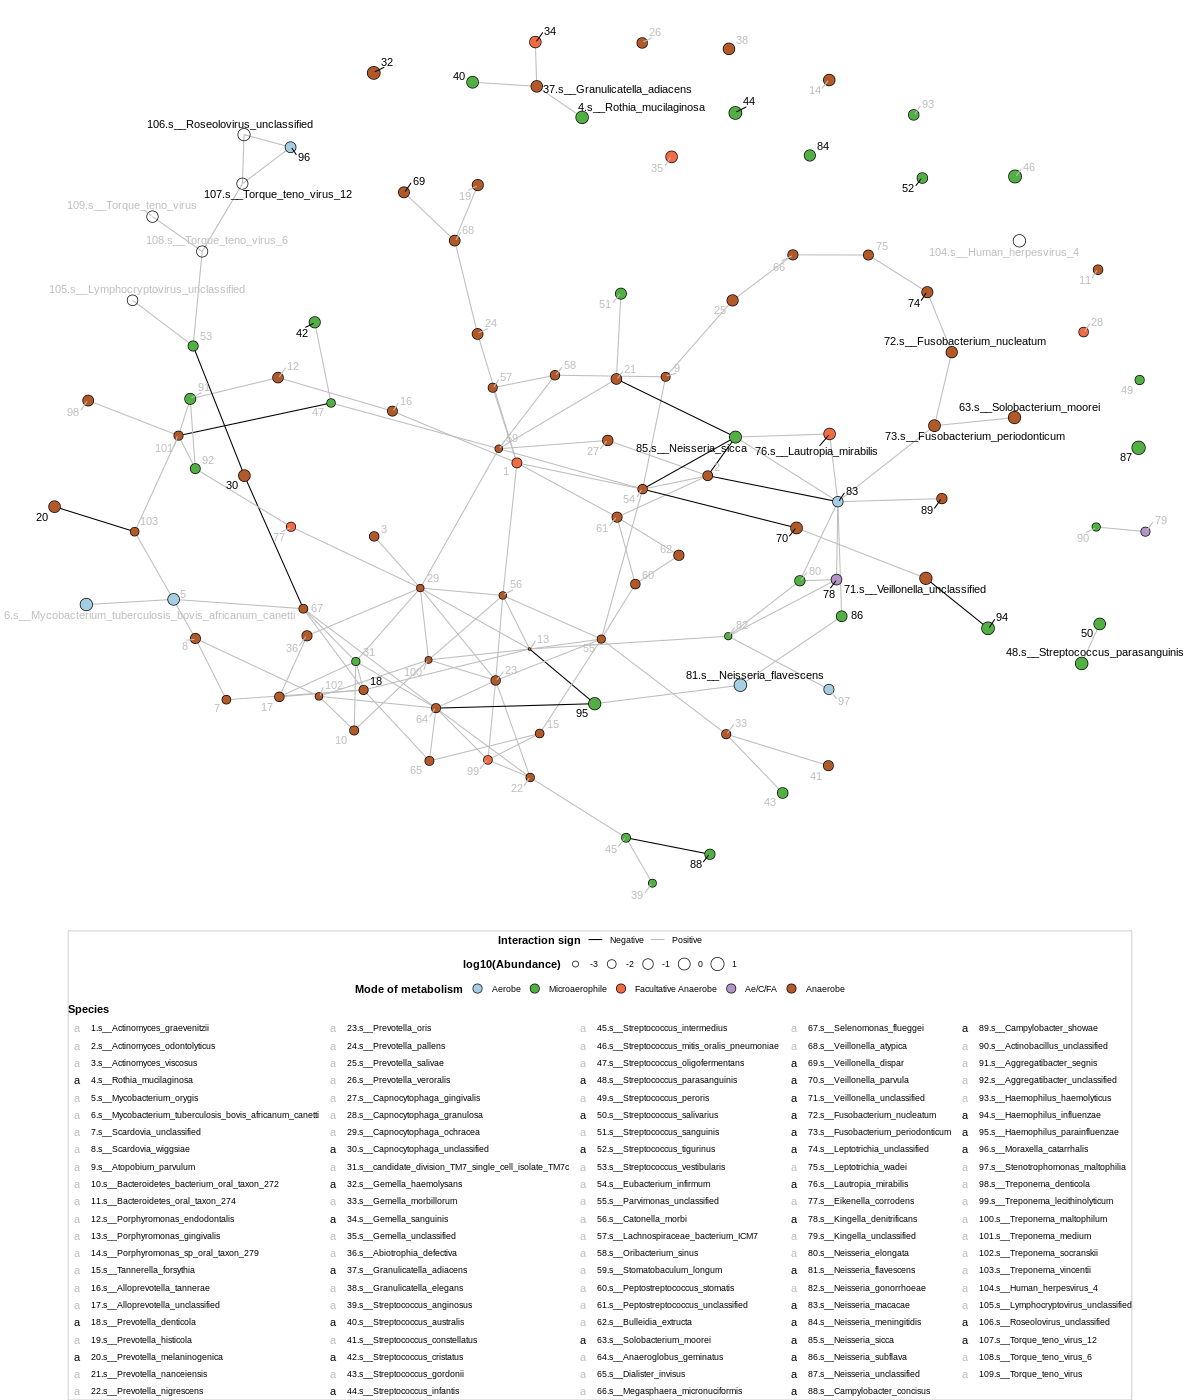

In [17]:
%%R -w 1200 -h 1400 -u px
print(par('din'))
set.seed(52) # For reprodicible layout of the graph
library(ggraph)
library(graphlayouts)

# Visualize the graph
#----------------------
# Labels for nodes
spp_labels_wtop10_andMyc <- seq(1,length(spp_name_labels))
spp_labels_wtop10_andMyc[selected_spp[1:10]] <- spp_name_labels[selected_spp[1:10]]
additional_ixs <- grep("Mycobacterium_tuberculosis|virus",spp_name_labels)
spp_labels_wtop10_andMyc[additional_ixs] <- spp_name_labels[additional_ixs]

# Color for labels
spp_labels_colors <- rep("grey",length(spp_labels_wtop10_andMyc))
spp_labels_colors[selected_spp] <- "black"

# Color for nodes
spp_node_colors <- colorRampPalette(brewer.pal(12, "Paired"))(length(levels(wms_spp_metabolism)))

wms_spp_spiec.ig.plot <- ggraph(wms_spp_SpiecEasi.ig, layout="fr") + 
                         geom_edge_link0(aes(colour=factor(sign))) + 
                         geom_node_point(aes(size=log10(Abundance), fill=wms_spp_metabolism), shape=21) + 
                         geom_node_text(aes(label=spp_labels_wtop10_andMyc, 
                                            colour=spp_labels_wtop10_andMyc),
                                        point.padding = unit(0.20, "lines"), repel=TRUE) +
                         scale_edge_colour_manual(name="Interaction sign", values=c("black","grey")) + 
                         scale_fill_manual(name="Mode of metabolism",
                                           breaks=levels(wms_spp_metabolism),
                                           values=spp_node_colors) + 
                         scale_colour_manual(name="Species", limits=spp_labels_wtop10_andMyc,
                                             labels=spp_name_labels, values=spp_labels_colors) +
                         theme_void() + 
                         guides(edge_colour=guide_legend(override.aes = list(size = 4), order=1), 
                                size=guide_legend(order=2),
                                fill=guide_legend(override.aes = list(size = 4), order=3),
                                colour=guide_legend(title.position='top',order=4)) +
                         theme(legend.position="bottom", legend.box = "vertical",
                               legend.title=element_text(face="bold"),
                               legend.box.background = element_rect(colour = "gray"))

wms_spp_spiec.ig.plot.file <- "./reports/figures/wms_spp_network.svg"
ggsave(wms_spp_spiec.ig.plot.file, wms_spp_spiec.ig.plot, width=16.66667, height=19.44444)

wms_spp_spiec.ig.plot

**Panel with Compositional biplots and interaction netwroks**

[1] 13.88889 11.11111


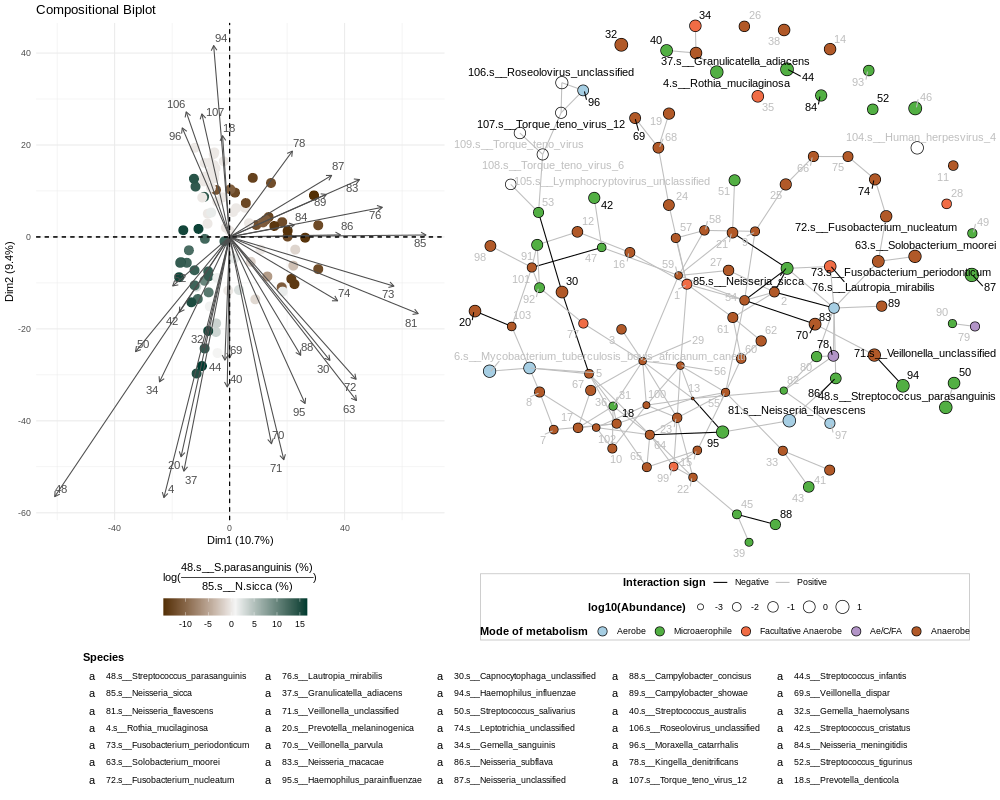

In [18]:
%%R -w 1000 -h 800 -u px
print(par('din'))
# Combining biplots and network
pca_biplot_network_panel_layout <- rbind(c(1,2),
                                         c(1,2),
                                         c(3,3))

wms_pca_biplot_network_panel <- grid.arrange(wms_spp_pca_biplot + theme(legend.position="bottom"),
                                             wms_spp_spiec.ig.plot + guides(colour=FALSE), 
                                             wms_spp_pca_varplot_legend,
                                             layout_matrix=pca_biplot_network_panel_layout, 
                                             widths=c(0.45,0.55), heights=c(0.6,0.2,0.2))
wms_pca_biplot_network_panel.file <- "./reports/figures/wms_spp_pca_biplot_network.svg"
ggsave(wms_pca_biplot_network_panel.file, wms_pca_biplot_network_panel, width=13.9, height=11.1)


### 2.4 Visualize the relationship between interacting species

**2.4.1 Species interacting with _Selenomonas spp._**

Lets find how many Selenomonas spp are part of the interaction network:

In [19]:
%%R
# Lets find how many Selenomonas spp are part of the interaction network
selenomonas_nodes_ix <- grep("Selenomonas",igraph::vertex_attr(wms_spp_SpiecEasi.ig,"name"))
cat("Number of Selenomonas spp. in the interactions network:")
cat(length(selenomonas_nodes_ix))
cat("\nSelenomonas spp. in interaction network:\n")
igraph::vertex_attr(wms_spp_SpiecEasi.ig,"name",selenomonas_nodes_ix)

Number of Selenomonas spp. in the interactions network:1
Selenomonas spp. in interaction network:
[1] "s__Selenomonas_flueggei"


were there other Selenomonas spp. present in the WMS-S dataset:

In [20]:
%%R
rowSums(wms_all_spp_counts_table > 0)[grep("Selenomonas",rownames(wms_all_spp_counts_table))]

 s__Selenomonas_flueggei     s__Selenomonas_noxia s__Selenomonas_sputigena 
                       3                        2                        1 


_Selenomonas flueggei_ was the only one that passed the prevalence threshold. 

Now, lets retrieve the spp. directly interacting with _Selenomonas flueggei_:

In [21]:
%%R
sflueggei_neighbors <- igraph::neighbors(wms_spp_SpiecEasi.ig, selenomonas_nodes_ix)$name
sflueggei_neighbors

[1] "s__Mycobacterium_orygis"                            "s__Prevotella_denticola"                            "s__Capnocytophaga_unclassified"                    
[4] "s__candidate_division_TM7_single_cell_isolate_TM7c" "s__Anaeroglobus_geminatus"                         


Lets extent the neighborhood to include nodes interacting with immediate neighboors of _S. flueggei_:

In [22]:
%%R
sflueggei_neighbors_order_2 <- unlist(igraph::ego(wms_spp_SpiecEasi.ig, 
                                                        order=2, 
                                                        nodes=selenomonas_nodes_ix))
names(sflueggei_neighbors_order_2)

 [1] "s__Selenomonas_flueggei"                               "s__Mycobacterium_orygis"                               "s__Prevotella_denticola"                              
 [4] "s__Capnocytophaga_unclassified"                        "s__candidate_division_TM7_single_cell_isolate_TM7c"    "s__Anaeroglobus_geminatus"                            
 [7] "s__Mycobacterium_tuberculosis_bovis_africanum_canetti" "s__Scardovia_unclassified"                             "s__Porphyromonas_gingivalis"                          
[10] "s__Alloprevotella_unclassified"                        "s__Dialister_invisus"                                  "s__Streptococcus_vestibularis"                        
[13] "s__Bacteroidetes_bacterium_oral_taxon_272"             "s__Capnocytophaga_ochracea"                            "s__Prevotella_nigrescens"                             
[16] "s__Prevotella_oris"                                    "s__Haemophilus_parainfluenzae"                         "s__Treponema_leci

Lets plot the subggraph of the _S. flueggei_ neighborhood:

[1] 11.111111  6.944444


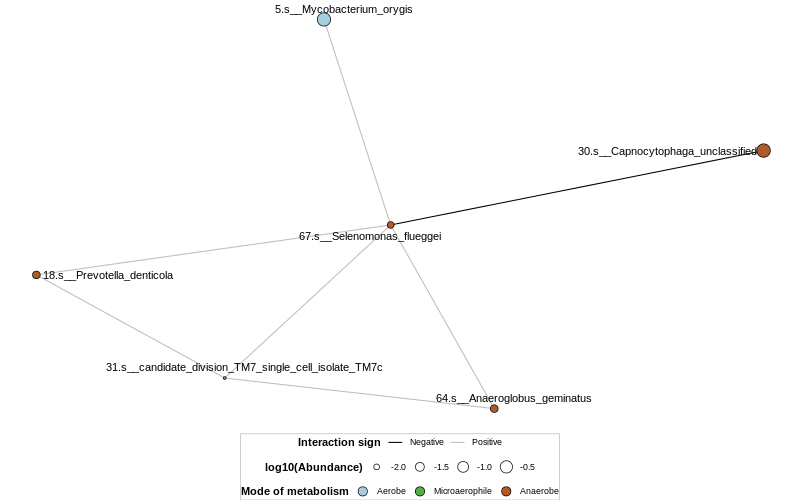

In [23]:
%%R -w 800 -h 500
print(par('din'))
set.seed(52) # For reprodicible layout of the graph
# Sub-graph of interactions with S. flueggei
sflueggei_subgraph <- igraph::subgraph(wms_spp_SpiecEasi.ig, 
                                       c("s__Selenomonas_flueggei",sflueggei_neighbors))

wms_sflueggei.ig2.plot <- ggraph(sflueggei_subgraph, layout="fr") + 
                            geom_edge_link0(aes(colour=factor(sign))) + 
                            geom_node_point(aes(size=log10(Abundance), 
                                                fill=Metabolism), 
                                                shape=21) + 
                            geom_node_text(aes(label=label),colour="black",
                                           point.padding = unit(0.20, "lines"), repel=TRUE) +
                            scale_edge_colour_manual(name="Interaction sign", values=c("black","grey")) + 
                            scale_fill_manual(name="Mode of metabolism",
                                              breaks=levels(wms_spp_metabolism),
                                              values=spp_node_colors) + 
                            theme_void() + 
                            guides(edge_colour=guide_legend(override.aes = list(size = 4), order=1), 
                                   size=guide_legend(order=2),
                                   fill=guide_legend(override.aes = list(size = 4), order=3)) +
                            theme(legend.position="bottom", legend.box = "vertical",
                                  legend.title=element_text(face="bold"),
                                  legend.box.background = element_rect(colour = "gray"))
wms_sflueggei.ig2.plot

Lets visualize the relative abundances of those species:

In [24]:
%%R
sort_hclust <- function(...) as.hclust(dendsort(as.dendrogram(...), isReverse = TRUE))

# Overwrite default draw_colnames in the pheatmap package.
# Thanks to Josh O'Brien at http://stackoverflow.com/questions/15505607
draw_colnames_45 <- function (coln, gaps, ...) {
    coord <- pheatmap:::find_coordinates(length(coln), gaps)
    x     <- coord$coord - 0.5 * coord$size
    res   <- grid::textGrob(
      coln, x = x, y = unit(1, "npc") - unit(3,"bigpts"),
      vjust = 0.75, hjust = 1, rot = 45, gp = grid::gpar(...)
    )
    return(res)
}
assignInNamespace(
  x = "draw_colnames",
  value = "draw_colnames_45",
  ns = asNamespace("pheatmap")
)

# Define legends for annotations
create_cont_gglegend <- function(name,values,limits=c(0,1),
                                 breaks=c(-0.1,0,0.2,0.4,0.6,0.8),
                                 colors=c("black","red"),position="bottom"){
    dummy_plot <- ggplot() +
    geom_tile(aes(x='1', y=values, fill=values)) + 
    scale_fill_gradientn(name=name,
                         values=rescale(values, to=c(0,1)),
                         limits=limits,
                         breaks=breaks,
                         colors=colors
                         ) + 
    theme_void() + 
    theme(legend.title=element_text(size=11,face='bold'), 
          legend.text=element_text(size=11))
    if(position=="bottom"){
        dummy_plot <- dummy_plot +
        theme(legend.position=position) +
        guides(fill=guide_colourbar(title.position="top",barwidth=10))

    }
    cowplot::get_legend(dummy_plot)
}

# Define legends for annotations
create_gglegend <- function(name,values,colors,position){
    dummy_plot <- ggplot() +
    geom_tile(aes(x='1', y=values, fill=values)) + 
    scale_fill_manual(name=name, 
                      breaks=levels(values),
                      values=colors, 
                      labels=levels(values)) + 
    theme_void() + 
    theme(legend.title=element_text(size=11,face='bold'), 
          legend.text=element_text(size=11))
    if(position=="bottom"){
        dummy_plot <- dummy_plot +
        theme(legend.position=position) +
        guides(fill=guide_legend(title.position="top",barwidth=10))
    }
    cowplot::get_legend(dummy_plot)
}

[1] 13.888889  2.777778


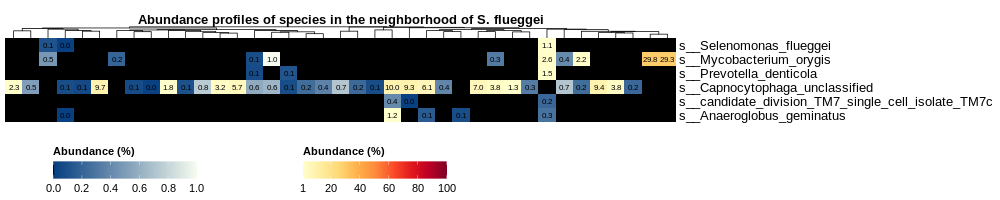

In [25]:
%%R -h 200 -w 1000 -u px
print(par('din'))

library(pheatmap)
library(dendsort)
library(vegan)
library(usedist)

# Define data to plot
# -------------------
# Species-level relative abundances
wms_Spp_ra_toplot <- wms_all_spp_abund_table
wms_Spp_ra_toplot <- wms_Spp_ra_toplot[c("s__Selenomonas_flueggei",sflueggei_neighbors),]

# remove samples that do not contain any of the spp. in the selenomonas neighborhood
wms_Spp_ra_toplot <- wms_Spp_ra_toplot[,colSums(wms_Spp_ra_toplot) >0]

# Ordering of samples based on Aitchison distances
wms_Spp_ra_toplot_cluster_samples <- sort_hclust(hclust(dist_subset(wms_all_spp_samples_pairwise_dist,
                                                                    colnames(wms_Spp_ra_toplot))))
wms_Spp_ra_toplot_cluster_species <- sort_hclust(hclust(dist_subset(wms_all_spp_species_pairwise_dist,
                                                                    rownames(wms_Spp_ra_toplot))))

# plot heatmap
# -------------------
# Define colors for pheatmap
color_palette_blues <- colorRampPalette(c("#f7fcf0", "#084081"))
color_palette_reds <- colorRampPalette(brewer.pal(9, "YlOrRd"))

# To color relative abundances with zero values in white
breaks_below1 <- seq(0,1, length.out=100) # below 1% in blue scale
breaks_above1 <- seq(1.05,100, length.out=100) # above 1%, colored from orange to red
color_breaks <- c(-0.1,breaks_below1,breaks_above1)
color_colors <- c("black",rev(color_palette_blues(length(breaks_below1))), 
                  color_palette_reds(length(breaks_above1)-1))

colorbar_blv1 <- create_cont_gglegend(name="Abundance (%)",
                                      values=breaks_below1,
                                      breaks=c(-0.1,0,0.2,0.4,0.6,0.8,1),
                                      limits=c(0,1),
                                      colors=c("black",rev(color_palette_blues(length(breaks_below1))))
                                     )
colorbar_abv0 <- create_cont_gglegend(name="Abundance (%)",
                                      values=seq(1.05,100, length.out=100),
                                      breaks=c(1,20,40,60,80,100),
                                      limits=c(1,100),
                                      colors=color_palette_reds(length(breaks_above1)-1))

wms_Spp_heatmap <- pheatmap(wms_Spp_ra_toplot,
                            color=color_colors,
                            breaks=color_breaks,
                            scale='none',
                            border_color=NA, 
                            show_rownames = TRUE,
                            #labels_row = genus_to_display_labels,
                            show_colnames= FALSE,
                            cellheight=14, 
                            fontsize_row=13,
                            cluster_cols=wms_Spp_ra_toplot_cluster_samples, 
                            cluster_rows=FALSE, 
                            #cutree_cols=3,
                            #cutree_rows=5,
                            treeheight_col=7,
                            treeheight_row=5,
                            #annotation_col=wms_bactSpp_sample_annotation, 
                            #annotation_row=wms_bactSpp_spp_annotation,
                            #annotation_colors=wms_bactSpp_annotation_colors,
                            annotation_names_row=FALSE,
                            #angle_col=315,
                            annotation_legend=FALSE, 
                            legend=FALSE,
                            display_numbers=TRUE,
                            number_format="%.1f",number_color="black",
                            main="Abundance profiles of species in the neighborhood of S. flueggei", 
                            silent=TRUE)

matrix_layout <- rbind(c(1,1,1,1),
                       c(2,3,NA,NA))
grid.arrange(grobs=list(wms_Spp_heatmap[[4]],
                        colorbar_blv1,
                        colorbar_abv0), 
             layout_matrix=matrix_layout,
             widths=c(0.25,0.25,0.25,0.25), heights=c(0.7,0.3))

The neighborhood of _Selenomonas flueggei_ in our inferred network was based on its detection in only three samples. Therefore, we have to be careful about any conjecture based on those interactions.

**2.4.2 Species interacting with _Fusobacterium spp._**

Lets find how many _Fusobacterium spp._ are part of the interaction network:

In [26]:
%%R
# Lets find how many Fusobacterium spp were part of the interaction network
fuso_nodes_ix <- grep("Fusobacterium",igraph::vertex_attr(wms_spp_SpiecEasi.ig,"name"))
cat("Number of Fusobacterium spp. in the interactions network:")
cat(length(fuso_nodes_ix))
cat("\nFusobacterium spp. in interaction network:\n")
igraph::vertex_attr(wms_spp_SpiecEasi.ig,"name",fuso_nodes_ix)

Number of Fusobacterium spp. in the interactions network:2
Fusobacterium spp. in interaction network:
[1] "s__Fusobacterium_nucleatum"     "s__Fusobacterium_periodonticum"


were there other Selenomonas spp. present in the WMS-S dataset?

In [27]:
%%R
rowSums(wms_all_spp_counts_table > 0)[grep("Fusobacterium",rownames(wms_all_spp_counts_table))]

    s__Fusobacterium_nucleatum s__Fusobacterium_periodonticum 
                            39                             27 


Now, lets retrieve the spp. directly interacting with _Fusobacterium spp._:

In [28]:
%%R
fusobacterium_neighbors <- unique(names(unlist(igraph::ego(wms_spp_SpiecEasi.ig, 
                                                           order=1, 
                                                           nodes=fuso_nodes_ix))))
fusobacterium_neighbors

[1] "s__Fusobacterium_nucleatum"     "s__Fusobacterium_periodonticum" "s__Leptotrichia_unclassified"   "s__Solobacterium_moorei"        "s__Neisseria_macacae"          


Lets plot the subgraph of the _Fusobacterium spp._ neighborhood:

[1] 8.333333 6.944444


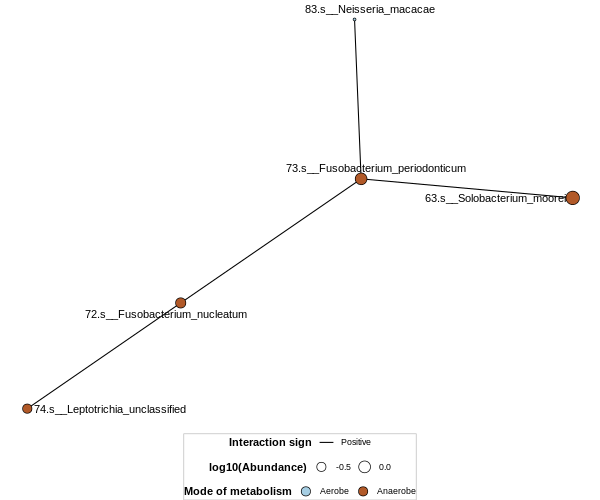

In [29]:
%%R -w 600 -h 500
print(par('din'))
set.seed(52) # For reprodicible layout of the graph
# Sub-graph of interactions with S. flueggei
fusobac_subgraph <- igraph::subgraph(wms_spp_SpiecEasi.ig, fusobacterium_neighbors)

wms_fusobac.ig2.plot <- ggraph(fusobac_subgraph, layout="fr") + 
                            geom_edge_link0(aes(colour=factor(sign))) + 
                            geom_node_point(aes(size=log10(Abundance), 
                                                fill=Metabolism), 
                                                shape=21) + 
                            geom_node_text(aes(label=label),colour="black",
                                           point.padding = unit(0.20, "lines"), repel=TRUE) +
                            scale_edge_colour_manual(name="Interaction sign", 
                                                     breaks=c("Negative","Positive"),
                                                     values=c("black","grey")) + 
                            scale_fill_manual(name="Mode of metabolism",
                                              breaks=levels(wms_spp_metabolism),
                                              values=spp_node_colors) + 
                            theme_void() + 
                            guides(edge_colour=guide_legend(override.aes = list(size = 4), order=1), 
                                   size=guide_legend(order=2),
                                   fill=guide_legend(override.aes = list(size = 4), order=3)) +
                            theme(legend.position="bottom", legend.box = "vertical",
                                  legend.title=element_text(face="bold"),
                                  legend.box.background = element_rect(colour = "gray"))
wms_fusobac.ig2.plot
